In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from pylab import rcParams
import scipy.cluster.hierarchy as sch

## Define two functions for cluster analysis visualisation

In [3]:
def pd_centers(featuresUsed, centers):
    from itertools import cycle, islice
    from pandas.plotting import parallel_coordinates
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data):
    from itertools import cycle, islice
    from pandas.plotting import parallel_coordinates
    import matplotlib.pyplot as plt

    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-2.5,+2.5])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    plt.xticks(rotation=75)

# **1) Prepare the dataset**

In [4]:
responses = pd.read_csv( "responses.csv")

responses.at[676,'Height'] += 100 # repair value

## 1.1) Divide dataset onto severall parts

In [156]:
music = responses.loc[:,'Dance':'Opera']
movies = responses.loc[:,'Horror':'Action']
hobbies = responses.loc[:,'History':'Pets']
phobias = responses.loc[:,'Flying':'Fear of public speaking']
personality = responses.loc[:,'Daily events':'Spending on healthy eating'].select_dtypes(include=['int','float'])

## **1.2) Define negation of 'breaveness' as a sum of individual's ratings of all fobias**
### Highter value = more brave

Text(0, 0.5, 'Density')

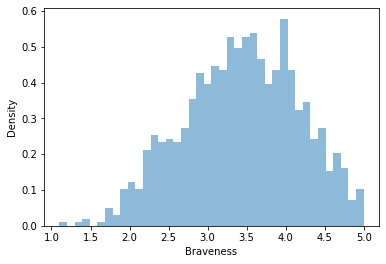

In [7]:
braveness = (50-phobias.sum(axis=1)) / 10 + 1
braveness.plot.hist(bins=40, alpha=0.5, density = True)

plt.xlabel('Braveness')
plt.ylabel('Density')

In [8]:
responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)

## **1.2) Filter responses leaving only numerical values**

In [9]:
responses_int = responses_.select_dtypes(include=['int','float'])
print( responses_.shape, responses_int.shape)

(1010, 151) (1010, 140)


# **2) Search for correlations**

## ** 2.1) Divide data set onto male/female slice**

In [10]:
responses_int_filtered = responses_int[ responses['Gender'] == 'female']
responses_male = responses_int[ responses['Gender'] == 'male']
responses_female = responses_int[ responses['Gender'] == 'female']

## 2.2) Generate plot of correlations with a chosen `FEATURE` using full dataset

List of features correlated with 'Number of friends':
--------------------------------
Fun with friends        0.369052
Loneliness             -0.287459
Number of friends       1.000000
Socializing             0.322625
Happiness in life       0.299404
Energy levels           0.367313
Personality             0.275306
Interests or hobbies    0.372215
Name: Number of friends, dtype: float64


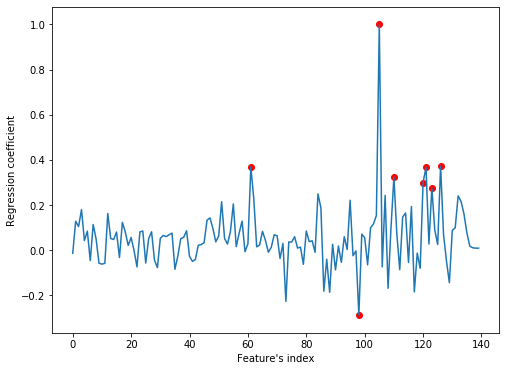

In [11]:
#FEATURE = 'Loneliness'
FEATURE = 'Number of friends'



rcParams['figure.figsize'] = 8,6

cols = responses_int_filtered.columns.to_list()

correlations = [ responses_int_filtered[FEATURE].corr(responses_int_filtered[f]) for f in cols ]


df = pd.DataFrame(correlations, columns = ['Correlations'])
df = df[ abs(df['Correlations']) > 0.25]

corr_features = [ cols[f] for f in df.index ]

corr = responses_int_filtered[corr_features].corr().loc[:,FEATURE]#.drop([FEATURE])
print( "List of features correlated with '{}':".format(FEATURE))
print( "--------------------------------")
print(corr)



plt.plot(correlations)
plt.xlabel('Feature\'s index')
plt.ylabel('Regression coefficient')
plt.scatter(df.index, np.array(corr), c='r')
plt.show()

List of features is in increasing order of `Feature's index`.

## 2.3) Search for interesting correlations for all of 'personality' features, distinguishing 2 genders.
Find features that lead to correlations with similar Pearson's value for both men and women treated separently

In [154]:
# index _1 stands for men, index_2 stands for women

for FEATURE in personality.columns:

    cols = responses_int_filtered.columns.to_list()

    correlations_1 = [ responses_male[FEATURE].corr(responses_male[f]) for f in cols ]
    correlations_2 = [ responses_female[FEATURE].corr(responses_female[f]) for f in cols ]



    df_1 = pd.DataFrame(correlations_1, columns = ['Correlations'])
    df_1 = df_1[ abs(df_1['Correlations']) > 0.25]
    df_2 = pd.DataFrame(correlations_2, columns = ['Correlations'])
    df_2 = df_2[ abs(df_2['Correlations']) > 0.25]


    corr_features_1 = [ cols[f] for f in df_1.index]
    corr_features_2 = [ cols[f] for f in df_2.index]


    corr_1 = responses_male[corr_features_1].corr().loc[:,FEATURE].drop([FEATURE])
    corr_2 = responses_female[corr_features_2].corr().loc[:,FEATURE].drop([FEATURE])

    # find set of features who are correlated independently of gender!
    set_ = set(corr_1.index) & set(corr_2.index)
    
    
    # if at least one distinct correlation is find
    if len(corr_1) > 0 and len(set_) > 0:

        print( "Feature name: ", FEATURE)
        print( "**********************")
        print( "List of correlated features:")
        print( "men:")
        print( "---------------")
        print( corr_1.loc[set_], "\n")
        print( "women:")
        print( "---------------")
        print( corr_2.loc[set_], "\n")
        print( "\n")

Feature name:  Daily events
**********************
List of correlated features:
men:
---------------
Law         0.296828
Politics    0.498691
Name: Daily events, dtype: float64 

women:
---------------
Law         0.256529
Politics    0.432398
Name: Daily events, dtype: float64 



Feature name:  Prioritising workload
**********************
List of correlated features:
men:
---------------
Workaholism      0.429130
Writing notes    0.373403
Name: Prioritising workload, dtype: float64 

women:
---------------
Workaholism      0.412899
Writing notes    0.367062
Name: Prioritising workload, dtype: float64 



Feature name:  Writing notes
**********************
List of correlated features:
men:
---------------
Workaholism              0.432640
Thinking ahead           0.268995
Prioritising workload    0.373403
Name: Writing notes, dtype: float64 

women:
---------------
Workaholism              0.387894
Thinking ahead           0.274745
Prioritising workload    0.367062
Name: Writing note

Feature name:  Personality
**********************
List of correlated features:
men:
---------------
Happiness in life    0.321400
Number of friends    0.273110
Energy levels        0.329834
Name: Personality, dtype: float64 

women:
---------------
Happiness in life    0.283123
Number of friends    0.275306
Energy levels        0.324834
Name: Personality, dtype: float64 



Feature name:  Interests or hobbies
**********************
List of correlated features:
men:
---------------
Adrenaline sports    0.274936
Number of friends    0.382497
Active sport         0.297284
Energy levels        0.492699
Socializing          0.299653
Name: Interests or hobbies, dtype: float64 

women:
---------------
Adrenaline sports    0.251788
Number of friends    0.372215
Active sport         0.350954
Energy levels        0.391811
Socializing          0.304017
Name: Interests or hobbies, dtype: float64 



Feature name:  Shopping centres
**********************
List of correlated features:
men:
----------

The method is to look into the output of above code, find most interesting features that don't depend on gender and plug their names as `FEATURE` in 2.1) block of code.

# 3) Clustering

## 3.1) Perform Hierarchical clustering for a chosen `FEATURE`

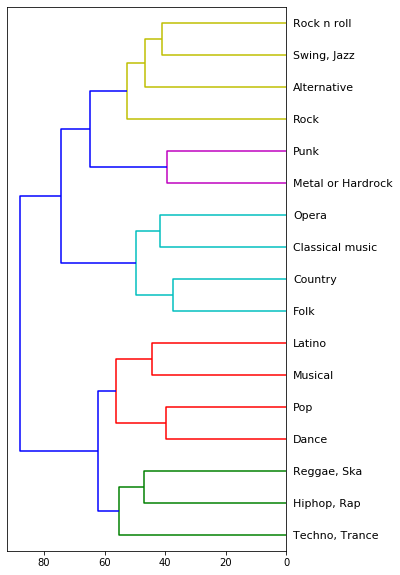

In [13]:
# [music, hobbies, phobias, personality]
FEATURE = music

df_select = FEATURE.copy(deep=True).dropna()
x = df_select.to_numpy().T
#
# Adjust figure size to accommodate the full tree
#
rcParams['figure.figsize'] = 5, 10
#
# Do hierarchical clustering using Ward's method
#
z = sch.linkage(x, method='ward')
#
# Display dendrogram
#
names = df_select.columns.tolist()
info = sch.dendrogram(z, orientation='left', labels=names, leaf_font_size=11)

### Comment 1): there seem to be 3 kinds of correlated fobias:
- animals (Rats, Snakes, Dangerous dogs, Spiders)
- nature (Darkness, Storm, Flying)
- social (Fear of public speaking, Heights, Ageing)

### Comment 2): music clusters in 5 similar types:
- **old music**: rock n roll, jazz, alternative
- **metal-like music**: rock**, punk, metal
- **instrumental music**": opera, classical, country, folk
- **popular music**: latino, musical, pop, dance
- **rap-like music**: reggae, hiphip, techno

** although rock was assigned to 'yellow label', it's not too far from 'magenta label', which seems more logical

## 3.2) Perform K-means clustering for people, basing on their phobias

In [14]:
# Generate a new dataframe by selecting the features you just defined

df_select = phobias.copy(deep=True).dropna()#$responses[select5features].copy(deep=True)

# Perform scaling on the dataframe containing the features

data = scale(df_select)




sse = {}
for k in range(1,11):
    model = KMeans(init='k-means++', n_clusters=k, n_init=20).fit(data)
    sse[k] = model.inertia_

## 3.2.1) Elbow method

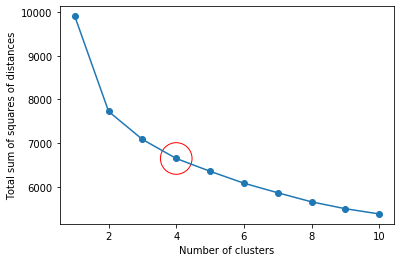

In [15]:
rcParams['figure.figsize'] = 6,4

plt.plot(list(sse.keys()), list(sse.values()), 'o', linestyle = '-')
plt.scatter( [4],[sse[4]], s = 1000, c = 'none', edgecolor = 'red')
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squares of distances')

# Define number of clusters
noOfClusters = 4

model = KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20).fit(data)

In [16]:
print(90*'_')
print("\nCount of people in each cluster")
print(90*'_')

pd.value_counts(model.labels_, sort=False)

__________________________________________________________________________________________

Count of people in each cluster
__________________________________________________________________________________________


0    199
1    283
2    253
3    255
dtype: int64

## 3.2.2) Plot centers of individual clusters

In [17]:
# Create a composite dataframe for plotting
# ... Use custom function declared in customplot.py (which we imported at the beginning of this notebook)


P = pd_centers(featuresUsed=phobias.columns.to_list(), centers=model.cluster_centers_)
P

,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,prediction
0,0.788497,1.329053,1.107851,0.780735,0.613163,0.824095,0.872969,0.477956,0.725130,0.387768,0
1,-0.511615,-0.533269,-0.692441,-0.662534,-0.716692,-0.783525,-0.745744,-0.606820,-0.661279,-0.590932,1
2,-0.230151,-0.207493,-0.224353,-0.252084,0.416560,0.707136,0.664089,0.178763,0.430834,-0.062667,2
3,0.180802,-0.239493,0.126509,0.376110,-0.096413,-0.475148,-0.512509,0.123096,-0.259450,0.415383,3


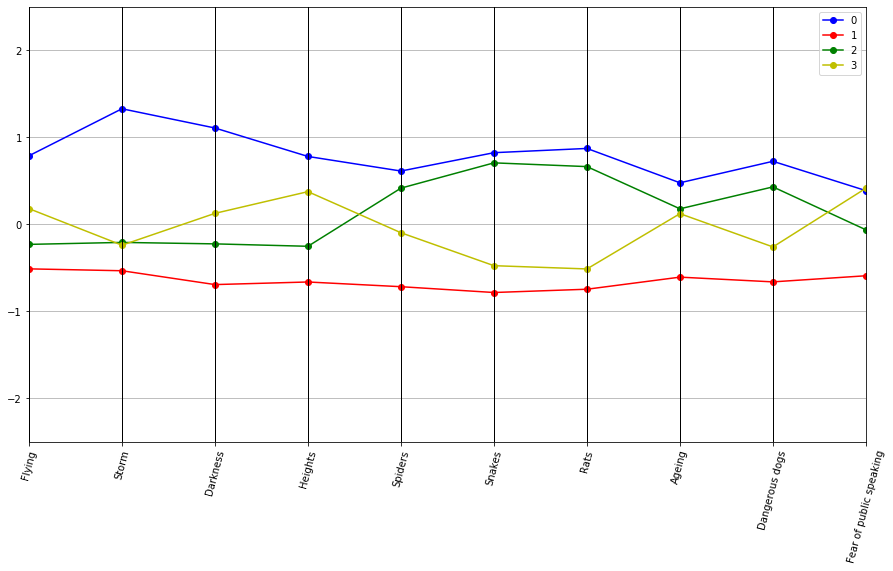

In [18]:
parallel_plot(P)

### Interpretation (valid for 4 clusters): people seem to divide in 4 different types:
 (note that the order of colors can change, look from bottom value line to top value line on label 'Flying')
 
- <font color='blue'>blue</font>: people scared of nothing.
- <font color='green'>green</font>: people scared of various animals.
- <font color='red'>red</font>: people scared of everything except of animals.
- <font color='orange'>yellow</font>: people scared of everything.

## 3.2.3) Find outliners

Number of survey responser and its distance from nearest cluster:

458 4.636745835403114
516 4.716400618883083
589 4.302815166790273
614 4.7199731594377035
932 4.325680229782651
989 4.433389879097406

All non-numeric informations about surveyors detected as outliers:


,Smoking,Only child,Village - town,Lying,House - block of flats,Education,Punctuality,Internet usage,Gender,Left - right handed,Alcohol
458,tried smoking,no,village,only to avoid hurting someone,house/bungalow,secondary school,i am often running late,few hours a day,female,right handed,social drinker
516,tried smoking,no,city,sometimes,block of flats,secondary school,i am always on time,few hours a day,male,right handed,never
589,current smoker,no,village,only to avoid hurting someone,block of flats,primary school,i am always on time,few hours a day,female,right handed,social drinker
614,current smoker,no,village,sometimes,house/bungalow,secondary school,i am often early,few hours a day,female,right handed,social drinker
932,tried smoking,no,city,sometimes,block of flats,secondary school,i am often early,few hours a day,female,right handed,social drinker
989,former smoker,no,village,sometimes,house/bungalow,masters degree,i am often early,most of the day,female,right handed,drink a lot


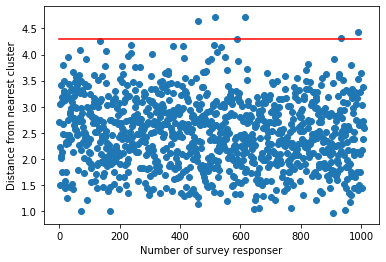

In [19]:
centers = model.cluster_centers_
RANGE = 4.3 # maximum allowed distance from nearest cluster to not be considered as an outliner


### plot distance from nearest cluster for all points for which cluster analysis was conducted
###
x = df_select.index.tolist()
y = [ min([ np.linalg.norm(a-b) for a in centers]) for b in data[:] ]
plt.scatter(x,y)
plt.plot( [0,1000], [RANGE,RANGE], 'red') # above this line are outliners
plt.xlabel("Number of survey responser")
plt.ylabel("Distance from nearest cluster")



### find which points are far away from any cluster. print their indexies and measured distances
###
print( "Number of survey responser and its distance from nearest cluster:\n")
for i in range( 0, len(y)):
    if y[i] > RANGE:
        print (x[i], y[i])


### select indexies of these points
###
outliners = [ i > RANGE for i in y]
outliners = df_select[ outliners]



### find all informations about people who seem to be outliners
###
filter_ = np.full( responses.shape[0], False)
for i in range( 0, outliners.shape[0]):
    filter_[ outliners.index[i]] = True
    
    
print( "\nAll non-numeric informations about surveyors detected as outliers:")
df_ = responses[ filter_]#.loc[:,'Daily events':'Spending on healthy eating']
   

# select columns including only strings
df_cols = set(df_.columns) - set(df_.select_dtypes(include=['int','float']).columns)
df_[df_cols]

### Comment: Seems like almost all of the outliners are woman.

# 4) Histogram analysis of `non-numerical` features
This corresponds to features like `gender` or `left/right handling`.
## 4.1) Perform BMI (body mass index) distribution analysis within genders

In [20]:
bmi = responses['Weight'] / (responses['Height'] / 100)**2

responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)
responses_.insert(0, "BMI", bmi.to_list(), True)



left_ = responses_[ responses_['Left - right handed'] == 'left handed']
right_ = responses_[ responses_['Left - right handed'] == 'right handed']

male_ = responses_[ responses_['Gender'] == 'male']
female_ = responses_[ responses_['Gender'] == 'female']

Text(0, 0.5, 'Density')

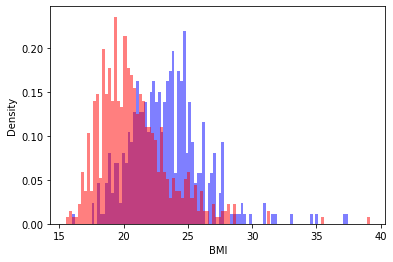

In [21]:
male_['BMI'].plot.hist(bins=100, alpha=0.5, color = 'blue', density = True)
female_['BMI'].plot.hist(bins=100, alpha=0.5, color = 'red', density = True)

rcParams['figure.figsize'] = 6,4
plt.xlabel('BMI')
plt.ylabel('Density')

### Interpretation: both genders have gaussian-like distribution of BMI values, however they mean values differ:
- women's average BMI is around 20
- men's average BMI is around 24

## 4.2) Compare woman's and man's faith (religious aspect)

Men's fraction distribution:


5.0    0.255474
1.0    0.236010
3.0    0.214112
4.0    0.160584
2.0    0.133820
Name: God, dtype: float64

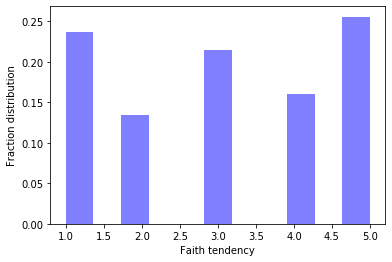

In [22]:
n = sum( male_['God'] == male_['God']) # disclude nan values in this feature's column

male_['God'].plot.hist(bins=11, alpha=0.5, color = 'blue', weights = [1./n for i in range(0,n)])
plt.xlabel('Faith tendency')
plt.ylabel('Fraction distribution')

print( "Men's fraction distribution:")
male_['God'].value_counts(normalize=True)

Women's fraction distribution:


5.0    0.358714
3.0    0.211506
4.0    0.165821
1.0    0.152284
2.0    0.111675
Name: God, dtype: float64

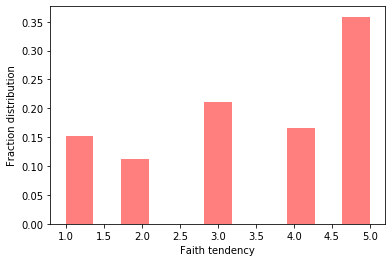

In [23]:
n = sum( female_['God'] == female_['God']) # disclude nan values in this column

female_['God'].plot.hist(bins=11, alpha=0.5, color = 'red', weights = [1./n for i in range(0,n)])
plt.xlabel('Faith tendency')
plt.ylabel('Fraction distribution')

print( "Women's fraction distribution:")
female_['God'].value_counts(normalize=True)

### Interpretation: woman are more likely to be religious.
- 36% of woman and 25% of men are strongly religious (5.0 points in survey).
- 15% of woman and 24% of men are atheist-like (1.0 point in survey).

# 5) Principal Component analysis

## 5.1) Calculate covarriance matrix and its eigenvectors aswell as eigenvalues

In [157]:
# select what slice of responders table you want to analyse
# choose TYPE from [music, hobbies, movies, phobias, personality]
TYPE = movies
N = 4

df = TYPE.dropna()
df_np = np.array(df)

# calculate covarriance matrix for all features (columns) in TYPE
Sigma = np.cov( df_np, rowvar=0, bias=1)

# calculate eigenvectors of covarriance matrix
eigenvalues, eigenvectors = np.linalg.eigh(Sigma)

## 5.2) Print fraction of total variance considered when taking into account only N biggest eigenvectors in terms of eigenvalues

In [158]:
print( sum(eigenvalues[-N:]) / sum(eigenvalues))

0.6444598855259794


In [159]:
# select N eigenvectors coresponding to N highest eigenvalues
U = eigenvectors[:,-N:]
# reverse the order so the first column corresponds to highest eigeinvalue
U = U[:,::-1]


# products of selected eigenvectors for each survey responder
rows = [(U.T).dot(row) for row in df_np]
# columns' names
cols = [chr(i) for i in range(97,97+N)]

# create a DataFrame containing `rows`, indexed like initial table after dropping NaNs
Big_Five = pd.DataFrame( rows, columns = cols, index = df.index.tolist())
# add N new features as new columns to initial slice of responders table
Big_Five = pd.concat([df,Big_Five], axis=1) 

## 5.3) Correlate N new variables with rest of the features

In [160]:
# display correlations between found N features and all initial features
corr_ = Big_Five.corr().loc[df.columns,cols]
corr_.style.background_gradient(cmap='coolwarm', low=0., high=0.3)

,a,b,c,d
Horror,-0.535215,0.0309583,0.749917,-0.179415
Thriller,-0.615426,-0.000449066,0.476329,-0.0734495
Comedy,0.0444655,-0.312498,0.204003,0.199404
Romantic,0.439811,-0.434911,0.173296,0.219201
Sci-fi,-0.603357,-0.25423,-0.0919016,0.575887
War,-0.658157,-0.126221,-0.348062,-0.358375
Fantasy/Fairy tales,0.255661,-0.842517,0.0987103,-0.114085
Animated,0.135865,-0.845927,0.148742,-0.113219
Documentary,-0.248598,-0.331022,-0.402476,-0.352805
Western,-0.543502,-0.172327,-0.3606,-0.0965979


### Comment 1): if `TYPE` = `music`, then 5 most frequent chronotypes (involving 62% of all responders) correspond to following interpretation:

- `a` - likes very much **rock/metal/jazz**, hates **rap/techno/pop**
- `b` - likes very much **dance/musical/pop/latino**, hates very much **metal/punk**
- `c` - likes very much **hiphop/rap/reggae/punk/techno**, hates very much **classical/musical/opera**
- `d` - likes **all kinds** of music, hates very much **techno**
- `e` - likes **pop/rock/metal**, hates **reggae/jazz/alternative**

notice that `a` chronotype is the most common

### What simplifices to:

- `a` - true metalhead
- `b` - pop music lover
- `c` - rapper
- `d` - all kinds of music person
- `e` - somehow like metalhead, but also likes pop


### Comment 2): if `TYPE` = `hobbies`, then 6 most frequent chronotypes (involving 48% of all responders) correspond to following interpretation:

- `a` - hates essentialy everything
- `b` - likes very much **mathematics/phisics/PC/cars/science/adrenaline sports**, hates **reading**
- `c` - likes very much **biology/chemistry/medicine**, hates very much **politics/economy/law**
- `d` - likes **mathematics/phisics/history/religion**, hates very much **celebrities/shopping/pets**
- `e` - likes very much **instruments**, hates **law/economy/politics**
- `f` - likes **history/geography**, hates **mathematics**

### What translates to following chronotypes:

- `a` - lazy person
- `b` - science person who adores activities
- `c` - medician
- `d` - science person who hates activities
- `e` - musician
- `f` - humanist

### Comment 3): if `TYPE` = `movies`, then 4 most frequent (involving 64% of all responders) movie preferences are following:

- `a` - romantic films (mostly women)
- `b` - essentialy nothing
- `c` - horror and thriller
- `d` - science fiction and action